In [127]:
import os
import csv
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import cv2
import pickle
from skimage.feature import hog
from skimage import io
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model
import math


# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)
from sklearn.metrics import classification_report,confusion_matrix
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image

Rename plant, in order to avoid mistakes with labeling using path:

In [261]:
# Path to the folder containing the images
folder_path = 'house_plant_species\Chinese Money Plant (Pilea peperomioides)'

# New base name for the images
new_base_name = 'Chinese_Money_Plant_(Pilea_peperomioides)_'

# Get a list of all the files in the folder
files = os.listdir(folder_path)

# Sort the files to ensure correct ordering, in case they're not in order
files.sort()

# Loop through the files and rename them
for i, filename in enumerate(files):
    # Get the file extension (e.g., .jpg or .png)
    file_extension = os.path.splitext(filename)[1]
    
    # Construct the new file name with the ordinal number
    new_name = f"{new_base_name}{i+1}{file_extension}"
    
    # Get the full old and new file paths
    old_file = os.path.join(folder_path, filename)
    new_file = os.path.join(folder_path, new_name)
    
    # Rename the file
    os.rename(old_file, new_file)
    print(f"Renamed: {filename} -> {new_name}")

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Yuliya Lavrenyuk\AppData\Local\Temp\ipykernel_2584\3874911451.py:2: SyntaxWarning: invalid escape sequence '\C'
  folder_path = 'house_plant_species\Chinese Money Plant (Pilea peperomioides)'


Renamed: Chinese Money Plant_212.webp -> Chinese_Money_Plant_(Pilea_peperomioides)_1.webp
Renamed: Chinese_1.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_2.jpg
Renamed: Chinese_10.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_3.jpg
Renamed: Chinese_100.jpeg -> Chinese_Money_Plant_(Pilea_peperomioides)_4.jpeg
Renamed: Chinese_101.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_5.jpg
Renamed: Chinese_102.jpeg -> Chinese_Money_Plant_(Pilea_peperomioides)_6.jpeg
Renamed: Chinese_103.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_7.jpg
Renamed: Chinese_104.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_8.jpg
Renamed: Chinese_105.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_9.jpg
Renamed: Chinese_106.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_10.jpg
Renamed: Chinese_107.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_11.jpg
Renamed: Chinese_108.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_12.jpg
Renamed: Chinese_109.jpg -> Chinese_Money_Plant_(Pilea_peperomioides)_

Rename folders:

In [5]:
# Path to image folders
base_dir = 'house_plant_species'

# Output CSV file
output_file = 'image_data.csv'

In [268]:
# Function to clean folder names by replacing spaces, parentheses, and special characters
def clean_folder_name(folder_name):
    # Replace spaces and special characters with underscores
    cleaned_name = folder_name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('-', '_')
    return cleaned_name

In [269]:
# Loop through all folders in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Clean the folder name
        new_folder_name = clean_folder_name(folder_name)
        new_folder_path = os.path.join(base_dir, new_folder_name)

        # Rename the folder if the cleaned name is different
        if new_folder_name != folder_name:
            os.rename(folder_path, new_folder_path)
            print(f'Renamed folder: {folder_name} -> {new_folder_name}')
        else:
            print(f'Folder already clean: {folder_name}')

Renamed folder: African Violet (Saintpaulia ionantha) -> African_Violet_Saintpaulia_ionantha
Renamed folder: Aloe Vera -> Aloe_Vera
Renamed folder: Anthurium (Anthurium andraeanum) -> Anthurium_Anthurium_andraeanum
Renamed folder: Areca Palm (Dypsis lutescens) -> Areca_Palm_Dypsis_lutescens
Renamed folder: Asparagus Fern (Asparagus setaceus) -> Asparagus_Fern_Asparagus_setaceus
Renamed folder: Begonia (Begonia spp.) -> Begonia_Begonia_spp.
Renamed folder: Bird of Paradise (Strelitzia reginae) -> Bird_of_Paradise_Strelitzia_reginae
Renamed folder: Birds Nest Fern (Asplenium nidus) -> Birds_Nest_Fern_Asplenium_nidus
Renamed folder: Boston Fern (Nephrolepis exaltata) -> Boston_Fern_Nephrolepis_exaltata
Folder already clean: Calathea
Renamed folder: Cast Iron Plant (Aspidistra elatior) -> Cast_Iron_Plant_Aspidistra_elatior
Renamed folder: Chinese evergreen (Aglaonema) -> Chinese_evergreen_Aglaonema
Renamed folder: Chinese Money Plant (Pilea peperomioides) -> Chinese_Money_Plant_Pilea_peper

In [128]:
# Define broader categories based on species
categories = {
    'flowering': [
        'African_Violet_Saintpaulia_ionantha', 'Anthurium_Anthurium_andraeanum', 'Begonia_Begonia_spp',
        'Bird_of_Paradise_Strelitzia_reginae', 'Chrysanthemum', 'Daffodils_Narcissus_spp', 'Lilium_Hemerocallis',
        'Tulip', 'Hyacinth_Hyacinthus_orientalis', 'Christmas_Cactus_Schlumbergera_bridgesii', 
        'Poinsettia_Euphorbia_pulcherrima', 'Lily_of_the_valley_Convallaria_majalis', 'Orchid'
    ],
    'palms_and_ferns': [
        'Areca_Palm_Dypsis_lutescens', 'Asparagus_Fern_Asparagus_setaceus', 'Birds_Nest_Fern_Asplenium_nidus',
        'Boston_Fern_Nephrolepis_exaltata', 'Sago_Palm_Cycas_revoluta', 'Parlor_Palm_Chamaedorea_elegans', 
        'Ponytail_Palm_Beaucarnea_recurvata', 'Rattlesnake_Plant_Calathea_lancifolia'
    ],
    'succulents_and_cacti': [
        'Aloe_Vera', 'Jade_plant_Crassula_ovata', 'Kalanchoe', 'Venus_Flytrap', 'Elephant_Ear_Alocasia_spp', 
        'Yucca', 'Ctenanthe'
    ],
    'foliage': [
        'Calathea', 'Monstera_Deliciosa_Monstera_deliciosa', 'Snake_plant_Sanseviera', 'Rubber_Plant_Ficus_elastica',
        'Peace_lily', 'Pothos_Ivy_arum', 'Cast_Iron_Plant_Aspidistra_elatior', 'Chinese_Money_Plant_Pilea_peperomioides',
        'Chinese_evergreen_Aglaonema', 'Dracaena', 'Dumb_Cane_Dieffenbachia_spp', 'English_Ivy_Hedera_helix', 
        'Iron_Cross_begonia_Begonia_masoniana', 'Money_Tree_Pachira_aquatica', 'Schefflera', 'Tradescantia', 
        'ZZ_Plant_Zamioculcas_zamiifolia', 'Prayer_Plant_Maranta_leuconeura', 'Polka_Dot_Plant_Hypoestes_phyllostachya'
    ]
}

In [187]:
# Get a list of all folders in the base directory
folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

print(len(folders))
print(folders)

47
['African_Violet_Saintpaulia_ionantha', 'Aloe_Vera', 'Anthurium_Anthurium_andraeanum', 'Areca_Palm_Dypsis_lutescens', 'Asparagus_Fern_Asparagus_setaceus', 'Begonia_Begonia_spp', 'Birds_Nest_Fern_Asplenium_nidus', 'Bird_of_Paradise_Strelitzia_reginae', 'Boston_Fern_Nephrolepis_exaltata', 'Calathea', 'Cast_Iron_Plant_Aspidistra_elatior', 'Chinese_evergreen_Aglaonema', 'Chinese_Money_Plant_Pilea_peperomioides', 'Christmas_Cactus_Schlumbergera_bridgesii', 'Chrysanthemum', 'Ctenanthe', 'Daffodils_Narcissus_spp', 'Dracaena', 'Dumb_Cane_Dieffenbachia_spp', 'Elephant_Ear_Alocasia_spp', 'English_Ivy_Hedera_helix', 'Hyacinth_Hyacinthus_orientalis', 'Iron_Cross_begonia_Begonia_masoniana', 'Jade_plant_Crassula_ovata', 'Kalanchoe', 'Lilium_Hemerocallis', 'Lily_of_the_valley_Convallaria_majalis', 'Money_Tree_Pachira_aquatica', 'Monstera_Deliciosa_Monstera_deliciosa', 'Orchid', 'Parlor_Palm_Chamaedorea_elegans', 'Peace_lily', 'Poinsettia_Euphorbia_pulcherrima', 'Polka_Dot_Plant_Hypoestes_phyllosta

In [5]:
# Create CSV file
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image_name', 'category', 'species'])

    # Loop through the species folders
    for species_folder in os.listdir(base_dir):
        species_path = os.path.join(base_dir, species_folder)

        # Ensure it's a directory
        if os.path.isdir(species_path):
            # Find the category for this species
            category = None
            for cat, species_list in categories.items():
                if species_folder in species_list:
                    category = cat
                    break

            # Loop through images in this species folder
            for image_file in os.listdir(species_path):
                if image_file.endswith(('.jpg', '.png')):  # Adjust extensions as needed
                    image_path = os.path.join(species_path, image_file)
                    writer.writerow([image_file, category, species_folder])

Building 1 stage of model:

In [188]:
# Load the CSV
df = pd.read_csv('image_data.csv')

In [189]:
# Check number of unique species (classes)
num_classes = df['species'].nunique()
print(f'Number of unique species (classes): {num_classes}')

Number of unique species (classes): 47


In [190]:
# Check the broad categories
category_counts = df['category'].value_counts()
print('\nNumber of images in each broad category:')
print(category_counts)

# Check how many species are in each category
species_per_category = df.groupby('category')['species'].nunique()
print('\nNumber of unique species in each broad category:')
print(species_per_category)

# Optional: Get a more detailed view of how many images are there for each species
species_image_counts = df['species'].value_counts()
print('\nNumber of images for each species:')
print(species_image_counts)


Number of images in each broad category:
category
foliage                 9297
flowering               6443
palms_and_ferns         3669
succulents_and_cacti    2420
Name: count, dtype: int64

Number of unique species in each broad category:
category
flowering               13
foliage                 19
palms_and_ferns          8
succulents_and_cacti     7
Name: species, dtype: int64

Number of images for each species:
species
Chinese_evergreen_Aglaonema                 838
Dumb_Cane_Dieffenbachia_spp                 819
Anthurium_Anthurium_andraeanum              749
Daffodils_Narcissus_spp                     711
Chinese_Money_Plant_Pilea_peperomioides     698
African_Violet_Saintpaulia_ionantha         676
Birds_Nest_Fern_Asplenium_nidus             647
Boston_Fern_Nephrolepis_exaltata            624
Christmas_Cactus_Schlumbergera_bridgesii    618
Cast_Iron_Plant_Aspidistra_elatior          616
Calathea                                    544
Ctenanthe                               

In [191]:
# Base directory where images are stored
base_dir = os.path.normpath('house_plant_species')

In [192]:
# Ensure species and image_name columns are strings and not NaN
df['species'] = df['species'].fillna('Unknown').astype(str)
df['image_name'] = df['image_name'].fillna('Unknown').astype(str)

# Combine the base directory, species folder, and image name to form the full image path
df['image_path'] = df.apply(lambda row: os.path.join(base_dir, row['species'].replace(' ', '_'), row['image_name']), axis=1)

# Extract image paths into an array
image_paths = df['image_path'].values
labels = df['category'].values

# Print unique categories to check for NaN or issues
print(set(labels))

{'succulents_and_cacti', 'palms_and_ferns', 'flowering', 'foliage'}


In [193]:
# # Encode the labels (convert species names to numerical labels)
label_to_index = {label: index for index, label in enumerate(sorted(set(labels)))}
# Create reverse mapping
index_to_label = {index: label for label, index in label_to_index.items()}

# Encode the labels using the label_to_index mapping
labels_encoded = [label_to_index[label] for label in labels]


In [194]:
print(label_to_index)
print(index_to_label)
print(labels_encoded)

{'flowering': 0, 'foliage': 1, 'palms_and_ferns': 2, 'succulents_and_cacti': 3}
{0: 'flowering', 1: 'foliage', 2: 'palms_and_ferns', 3: 'succulents_and_cacti'}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Function to check if an image is valid
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify if it's a valid image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image detected: {image_path} - {e}")
        return False

invalid_images = []

# Loop through all folders and check all images
for species_folder in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species_folder)
    
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            image_path = os.path.join(species_path, image_file)
            
            # Check if the file is a valid image
            if not is_valid_image(image_path):
                invalid_images.append(image_path)

# Print out invalid images
if invalid_images:
    print(f"\nFound {len(invalid_images)} invalid images:")
    for invalid_image in invalid_images:
        print(invalid_image)
else:
    print("All images are valid!")

In [196]:
# Split the data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels_encoded, test_size=0.2, random_state=42)

In [197]:
train_paths

array(['house_plant_species\\Chinese_Money_Plant_Pilea_peperomioides\\Chinese_Money_Plant_(Pilea_peperomioides)_61.jpg',
       'house_plant_species\\Kalanchoe\\Image_20.jpg',
       'house_plant_species\\Rubber_Plant_Ficus_elastica\\Image_70.jpg',
       ..., 'house_plant_species\\Calathea\\Image_134.jpg',
       'house_plant_species\\Aloe_Vera\\Aloe_58.jpg',
       'house_plant_species\\Parlor_Palm_Chamaedorea_elegans\\Parlor_161.jpg'],
      dtype=object)

In [198]:
val_paths

array(['house_plant_species\\Hyacinth_Hyacinthus_orientalis\\Image_81.jpg',
       'house_plant_species\\Money_Tree_Pachira_aquatica\\Money_353.jpg',
       'house_plant_species\\Chinese_Money_Plant_Pilea_peperomioides\\Image_342.jpg',
       ...,
       'house_plant_species\\Dumb_Cane_Dieffenbachia_spp\\Image_14.jpg',
       'house_plant_species\\Lily_of_the_valley_Convallaria_majalis\\Lily_134.jpg',
       'house_plant_species\\Polka_Dot_Plant_Hypoestes_phyllostachya\\Polka_122.jpg'],
      dtype=object)

In [199]:
print( len(train_labels), len(val_labels))

17463 4366


In [200]:
# Function to extract color histogram features
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found or corrupted: {image_path}")
        return None
    image = cv2.resize(image, (256, 256))  # Resize image to a fixed size
    # Convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Extract color histograms for each channel (R, G, B)
    hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256]).flatten()
    hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256]).flatten()
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([hist_r, hist_g, hist_b])
    
    return hist_features

In [201]:
# Extract features for the training set
train_features = []
for image_path in train_paths:
    features = extract_features(image_path)
    if features is not None:
        train_features.append(features)

train_features = np.array(train_features)

# Extract features for the validation set
val_features = []
for image_path in val_paths:
    features = extract_features(image_path)
    if features is not None:
        val_features.append(features)

val_features = np.array(val_features)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

print("Feature extraction complete.")
print("Train feature shape:", train_features.shape)
print("Validation feature shape:", val_features.shape)

Feature extraction complete.
Train feature shape: (17463, 768)
Validation feature shape: (4366, 768)


In [202]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(train_features, train_labels)

# Make predictions on the validation set
val_predictions = rf_classifier.predict(val_features)

# Evaluate the accuracy of the model
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.6486


In [204]:
# Save the model
with open('rf_classifier_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

print("Model saved to rf_classifier_model.pkl")

Model saved to rf_classifier_model.pkl


In [205]:
# Save features and labels for the training set
with open('train_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)

with open('train_labels.pkl', 'wb') as f:
    pickle.dump(train_labels, f)

# Save features and labels for the validation set
with open('val_features.pkl', 'wb') as f:
    pickle.dump(val_features, f)

with open('val_labels.pkl', 'wb') as f:
    pickle.dump(val_labels, f)

print("Features and labels saved as .pkl files.")

Features and labels saved as .pkl files.


In [206]:
# Classification report
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1283
           1       0.59      0.86      0.70      1848
           2       0.73      0.37      0.49       749
           3       0.88      0.15      0.25       486

    accuracy                           0.65      4366
   macro avg       0.73      0.52      0.54      4366
weighted avg       0.69      0.65      0.62      4366

Confusion Matrix:
[[ 894  362   24    3]
 [ 196 1586   62    4]
 [  46  420  280    3]
 [  78  317   19   72]]


In [22]:
print(label_to_index)

{'flowering': 0, 'foliage': 1, 'palms_and_ferns': 2, 'succulents_and_cacti': 3}


Feature improvement within RF model:

In [20]:
# Function to extract combined features (color histograms + HOG)
def extract_combined_features(image_path):
    # Open image using PIL to handle transparency
    image = Image.open(image_path)
    
    # Convert palette images with transparency to RGBA
    if image.mode in ('P', 'RGBA', 'LA'):  # Convert if image has transparency
        image = image.convert('RGBA')
    
    # Convert image back to an array for OpenCV processing
    image = np.array(image)

    # Handle alpha channel if present (transparency)
    if image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)  # Remove alpha channel

    if image is None:
        return None

    # Color Histogram Features
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()  # Red channel
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256]).flatten()  # Green channel
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256]).flatten()  # Blue channel
    hist_features = np.concatenate([hist_r, hist_g, hist_b])

    # HOG Features
    image_resized = cv2.resize(image, (128, 128))  # Resize for HOG
    hog_features, _ = hog(image_resized, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, channel_axis=-1)  # Updated to channel_axis

    # Combine features
    combined_features = np.concatenate([hist_features, hog_features])
    return combined_features

# Extract combined features for training and validation sets
train_combined_features = [extract_combined_features(path) for path in train_paths]
train_combined_features = np.array([feat for feat in train_combined_features if feat is not None])  # Filter None values

val_combined_features = [extract_combined_features(path) for path in val_paths]
val_combined_features = np.array([feat for feat in val_combined_features if feat is not None])  # Filter None values

# Train Random Forest with combined features
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_combined_features, train_labels)

# Predict and evaluate
val_predictions = rf_classifier.predict(val_combined_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy with Combined Features: {val_accuracy:.4f}")

Validation Accuracy with Combined Features: 0.6086


In [24]:
# Save the model
with open('rf_2__classifier_model_lower_accuracy.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

print("Model saved to rf_classifier_model.pkl")

Model saved to rf_classifier_model.pkl


In [23]:
# Classification report
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      1283
           1       0.55      0.87      0.67      1848
           2       0.85      0.29      0.43       749
           3       0.98      0.10      0.19       486

    accuracy                           0.61      4366
   macro avg       0.77      0.47      0.49      4366
weighted avg       0.69      0.61      0.57      4366

Confusion Matrix:
[[ 774  502    7    0]
 [ 203 1616   29    0]
 [  45  487  216    1]
 [  75  357    3   51]]


test:

In [207]:
# Function to load the saved model
def load_model(filename='rf_classifier_model.pkl'):
    """
    Loads the saved model from a file using pickle.

    Parameters:
    - filename: The name of the file to load the model from.

    Returns:
    - The loaded machine learning model.
    """
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

In [208]:
# Function to predict the class of a test image
def predict_image_class(model, image_path):
    """
    Predicts the class of the given image using the provided model.

    Parameters:
    - model: The trained machine learning model.
    - image_path: Path to the image file.

    Returns:
    - The predicted class label.
    """
    features = extract_features(image_path)
    if features is None:
        return None
    features = features.reshape(1, -1)  # Reshape for a single sample
    prediction = model.predict(features)
    return prediction[0]

In [212]:
image_path = 'test_images\images (4).jpg'

In [213]:
model = load_model(r'saved_models\rf_classifier_model.pkl')

Model loaded from saved_models\rf_classifier_model.pkl


In [214]:
# Predict the class of the test image
predicted_class = predict_image_class(model, image_path)

if predicted_class is not None:
    print(f"The predicted class for the test image is: {predicted_class}")
else:
    print("Failed to predict the class of the test image.")

The predicted class for the test image is: 1


2 Stage with CNN model:

In [6]:
batch_size = 32
img_size = 128

In [39]:
base_dir ='house_plant_species'

Train models for each classes:

In [245]:
def train_model(chosen_category, categories, base_dir='house_plant_species', img_size=128, batch_size=32, epochs=30):

    
    # Image data generator with augmentation
    data_gen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
    )

    # Train Generator
    train_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        classes=categories[chosen_category],  # Include only the classes from the chosen category
        subset='training',
        class_mode='categorical'
    )

    # Validation Generator
    validation_generator = data_gen.flow_from_directory(
        base_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        classes=categories[chosen_category],  # Include only the classes from the chosen category
        subset='validation',
        class_mode='categorical'
    )

    # Get the number of classes for the chosen category
    num_classes = len(categories[chosen_category])

    # Get the mapping from class names to class indices
    class_indices = train_generator.class_indices  # Dictionary mapping class names to indices

    # Invert the mapping to get indices to class names
    indices_to_labels = dict((v, k) for k, v in class_indices.items())

    # Get the number of classes for the chosen category
    num_classes = len(categories[chosen_category])

    # Build and compile the model
    model = Sequential()

    # Convolutional layers with batch normalization and dropout
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # Flatten the output
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer for the specific number of classes
    model.add(Dense(units=num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model.summary()

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

    return model, history, indices_to_labels

In [248]:
chosen_category = 'flowering'
model, history, indices_to_labels = train_model(chosen_category, categories)

Found 5580 images belonging to 13 classes.
Found 1388 images belonging to 13 classes.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 953,613 (3.64 MB)

 Trainable params: 952,525 (3.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.2202 - loss: 2.6447 - val_accuracy: 0.0574 - val_loss: 3.2376
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3125 - loss: 2.4233 - val_accuracy: 0.0000e+00 - val_loss: 2.8810
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.3705 - loss: 1.9058 - val_accuracy: 0.1126 - val_loss: 2.8509
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - accuracy: 0.4375 - loss: 1.5539 - val_accuracy: 0.0833 - val_loss: 2.6809
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.4548 - loss: 1.6637 - val_accuracy: 0.3474 - val_loss: 1.9960
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - accuracy: 0.6562 - loss: 0.9645 - val_accuracy: 0.0833 - val_loss: 2.5522
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.4719 - loss: 1.6029 - val_accuracy: 0.4157 - val_loss: 1.7752
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.5625 - loss: 1.2734 - va

In [243]:
# Create a mapping from class indices to class names
# saving the class names as json file
json.dump(indices_to_labels , open(f'class_indices_{chosen_category}.json', 'w'))

In [244]:
  # Save the model with a name that reflects the chosen category
model_name = f'my_model_{chosen_category}_128_for_project.keras'
model.save(model_name)
print(f'Model saved as {model_name}')

Model saved as my_model_succulents_and_cacti_128_for_project.keras


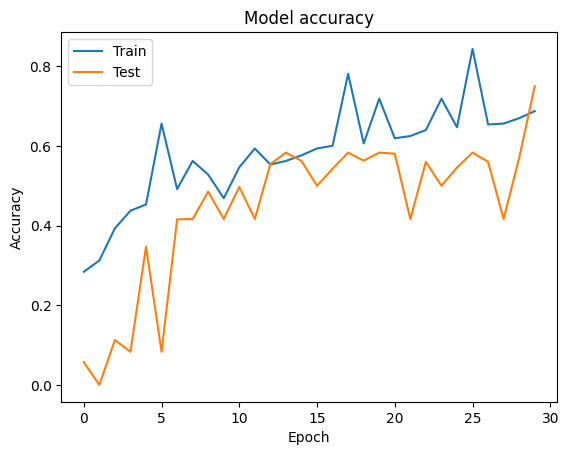

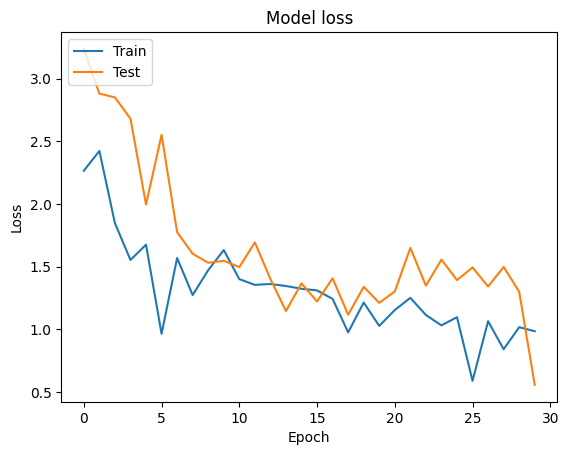

In [249]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Test:

In [ ]:
tf.keras.models.load_model

In [216]:
model = tf.keras.models.load_model('my_model_flowering_128.keras')

In [253]:
# Load the class indices from the JSON file
with open('class_indices_flowering.json', 'r') as f: # update with required category
    indices_to_labels = json.load(f)

In [257]:
#Load and preprocess the test image

img_path = r'test_images\images (1).jpg' 
img_size = 128  # Should match the input size of your model

In [258]:
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

In [259]:
# Make a prediction
prediction = model.predict(img_array)

# Get the index of the predicted class
predicted_class_idx = np.argmax(prediction, axis=1)[0]

# Map the predicted class index to the class label
predicted_label = indices_to_labels[str(predicted_class_idx)]

print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Predicted label: Hyacinth_Hyacinthus_orientalis


In [260]:
predicted_class_idx

8

In [261]:
# Get the sorted indices of the predictions in descending order
sorted_indices = np.argsort(prediction[0])[::-1]

In [262]:
# Get the top 3 class indices
top_3_indices = sorted_indices[:3]

# Get the top 3 probabilities
top_3_probs = prediction[0][top_3_indices]

# Map the top 3 indices to their corresponding labels
top_3_labels = [indices_to_labels[str(idx)] for idx in top_3_indices]

In [263]:
print("Top 3 Predictions:")
for i in range(3):
    print(f"{i+1}. {top_3_labels[i]}: {top_3_probs[i]*100:.2f}%")

Top 3 Predictions:
1. Hyacinth_Hyacinthus_orientalis: 99.92%
2. Chrysanthemum: 0.08%
3. Begonia_Begonia_spp: 0.00%


In [267]:
class_labels = indices_to_labels.values()

In [268]:
# Initialize an empty dictionary to store the mapping of class labels to image paths
class_label_to_image_path = {}

# Loop through each class label and find an image for each label in the base directory
for label in class_labels:
    # Construct the path to the class label's directory
    label_dir = os.path.join(base_dir, label)
    
    # Check if the directory exists
    if os.path.exists(label_dir):
        # Get the first image in the directory (you can adjust this if needed)
        for file_name in os.listdir(label_dir):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's an image
                image_path = os.path.join(label_dir, file_name)
                class_label_to_image_path[label] = image_path
                break  # Stop after finding the first image
    else:
        print(f"Warning: Directory for {label} not found!")

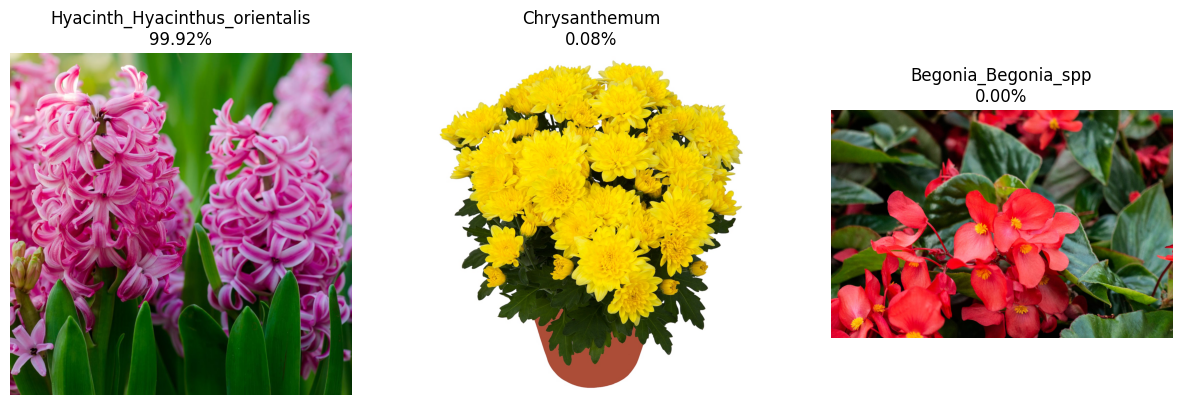

In [269]:
# Plot the images corresponding to the top 3 predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 subplot for the top 3 images

for i in range(3):
    label = top_3_labels[i]
    image_path = class_label_to_image_path[label]  # Get the image path for the label
    
    # Load and display the image
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(f"{label}\n{top_3_probs[i] * 100:.2f}%", fontsize=12)

plt.show()

Layers visualisation:

In [270]:
print(model.layers)
print(len(model.layers))

[<Conv2D name=conv2d_55, built=True>, <BatchNormalization name=batch_normalization_55, built=True>, <MaxPooling2D name=max_pooling2d_55, built=True>, <Conv2D name=conv2d_56, built=True>, <Dropout name=dropout_44, built=True>, <BatchNormalization name=batch_normalization_56, built=True>, <MaxPooling2D name=max_pooling2d_56, built=True>, <Conv2D name=conv2d_57, built=True>, <BatchNormalization name=batch_normalization_57, built=True>, <MaxPooling2D name=max_pooling2d_57, built=True>, <Conv2D name=conv2d_58, built=True>, <Dropout name=dropout_45, built=True>, <BatchNormalization name=batch_normalization_58, built=True>, <MaxPooling2D name=max_pooling2d_58, built=True>, <Conv2D name=conv2d_59, built=True>, <Dropout name=dropout_46, built=True>, <BatchNormalization name=batch_normalization_59, built=True>, <MaxPooling2D name=max_pooling2d_59, built=True>, <Flatten name=flatten_11, built=True>, <Dense name=dense_22, built=True>, <Dropout name=dropout_47, built=True>, <Dense name=dense_23, bu

In [271]:
# Use the input tensor of the first layer
input_tensor = model.layers[0].input
input_tensor

<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=False, name=keras_tensor_4059>

In [272]:
# Get the outputs of all layers
layer_outputs = [layer.output for layer in model.layers]

In [273]:
# Print all layers in the model
print("Model Layers:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} ({layer.__class__.__name__})")

Model Layers:
Layer 0: conv2d_55 (Conv2D)
Layer 1: batch_normalization_55 (BatchNormalization)
Layer 2: max_pooling2d_55 (MaxPooling2D)
Layer 3: conv2d_56 (Conv2D)
Layer 4: dropout_44 (Dropout)
Layer 5: batch_normalization_56 (BatchNormalization)
Layer 6: max_pooling2d_56 (MaxPooling2D)
Layer 7: conv2d_57 (Conv2D)
Layer 8: batch_normalization_57 (BatchNormalization)
Layer 9: max_pooling2d_57 (MaxPooling2D)
Layer 10: conv2d_58 (Conv2D)
Layer 11: dropout_45 (Dropout)
Layer 12: batch_normalization_58 (BatchNormalization)
Layer 13: max_pooling2d_58 (MaxPooling2D)
Layer 14: conv2d_59 (Conv2D)
Layer 15: dropout_46 (Dropout)
Layer 16: batch_normalization_59 (BatchNormalization)
Layer 17: max_pooling2d_59 (MaxPooling2D)
Layer 18: flatten_11 (Flatten)
Layer 19: dense_22 (Dense)
Layer 20: dropout_47 (Dropout)
Layer 21: dense_23 (Dense)


In [274]:
# Create the activation model
activation_model = Model(inputs=input_tensor, outputs=layer_outputs)

In [275]:
activations = activation_model.predict(img_array) 
# Returns a list of five Numpy arrays: one array per layer activation

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [276]:
len(activations)

22



Visualizing Layer 0: conv2d_55




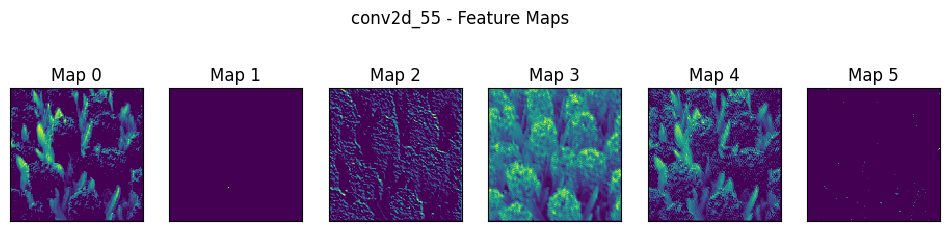



Visualizing Layer 1: batch_normalization_55




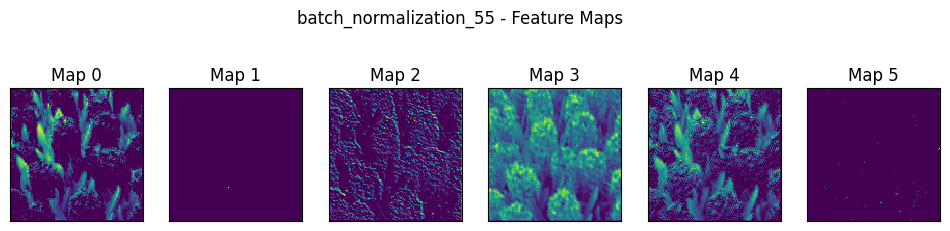



Visualizing Layer 2: max_pooling2d_55




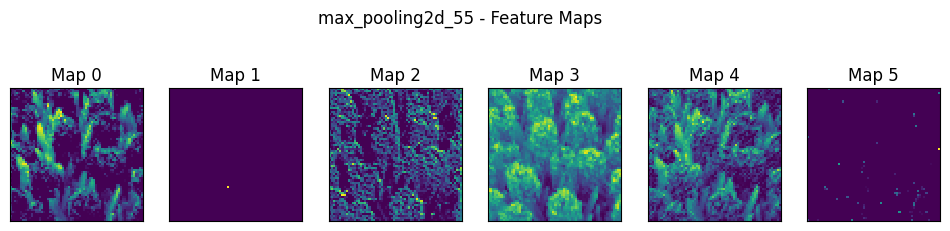



Visualizing Layer 3: conv2d_56




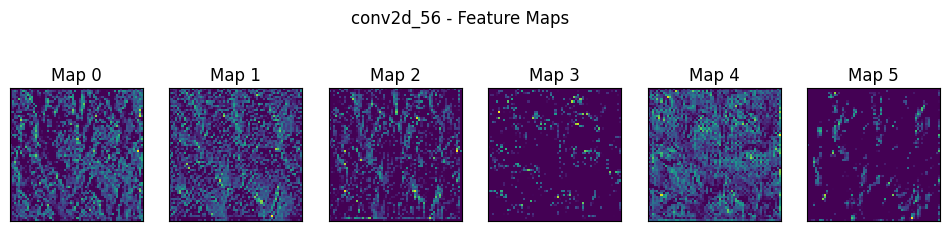



Visualizing Layer 4: dropout_44




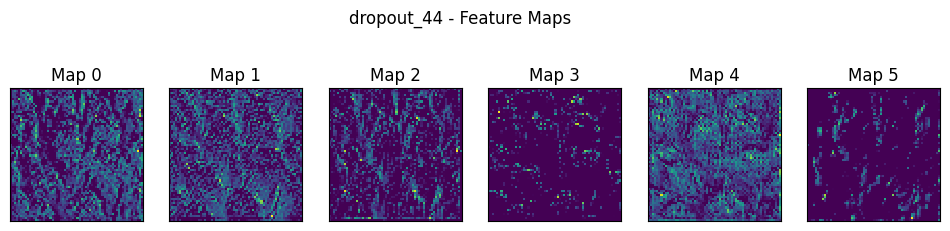



Visualizing Layer 5: batch_normalization_56




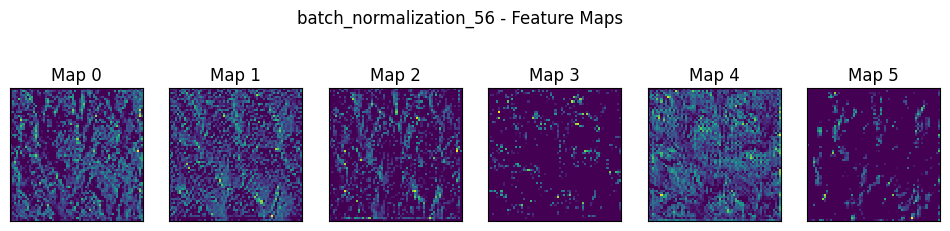



Visualizing Layer 6: max_pooling2d_56




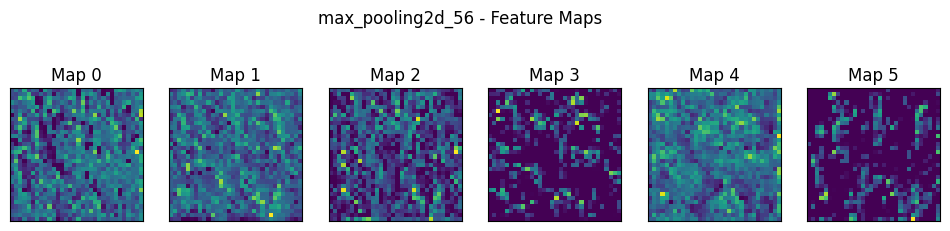



Visualizing Layer 7: conv2d_57




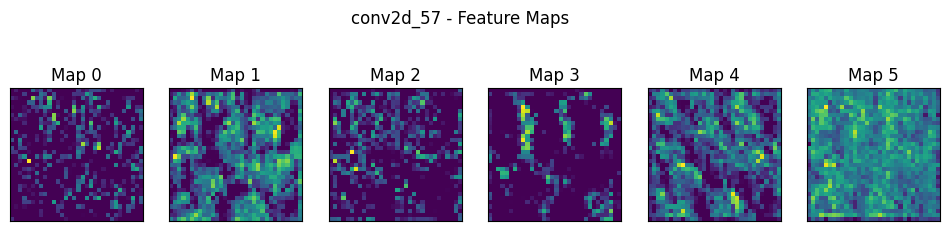



Visualizing Layer 8: batch_normalization_57




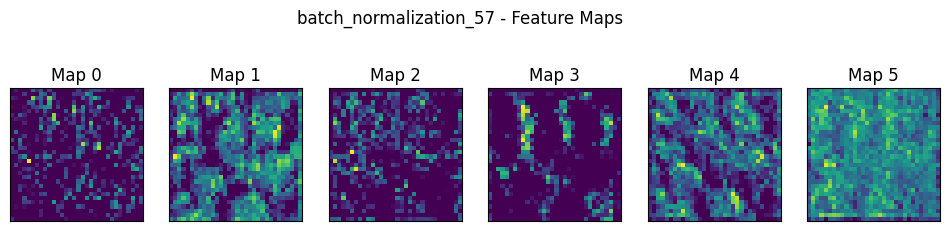



Visualizing Layer 9: max_pooling2d_57




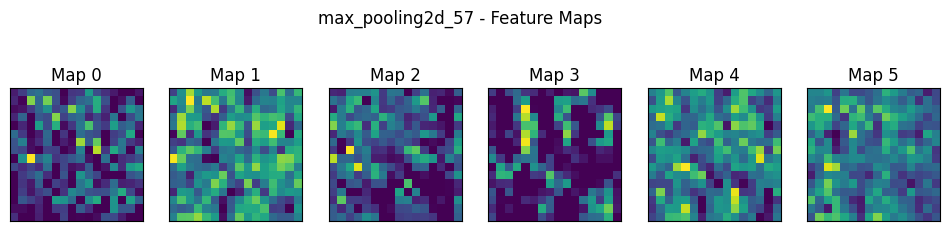



Visualizing Layer 10: conv2d_58




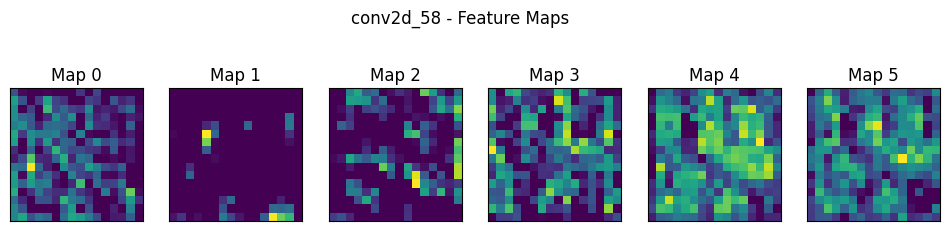



Visualizing Layer 11: dropout_45




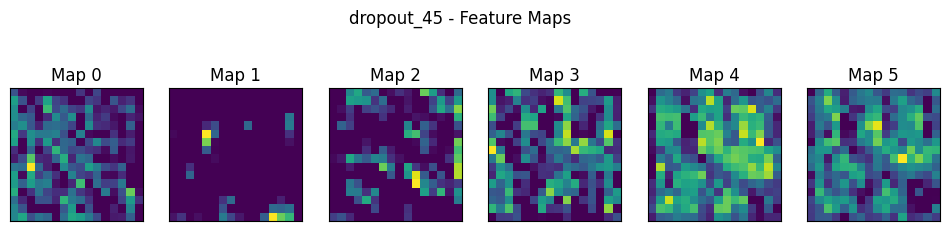



Visualizing Layer 12: batch_normalization_58




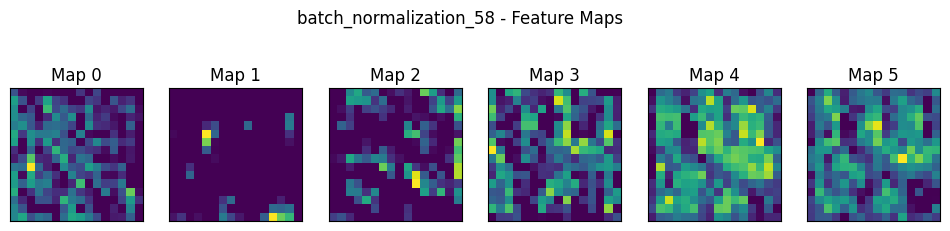



Visualizing Layer 13: max_pooling2d_58




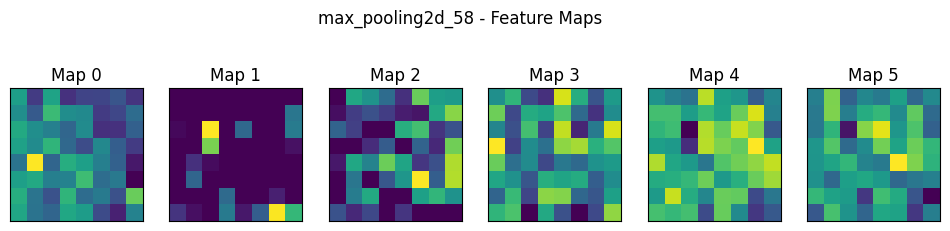



Visualizing Layer 14: conv2d_59




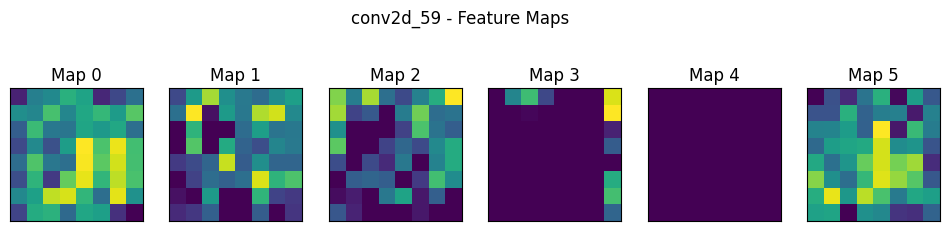



Visualizing Layer 15: dropout_46




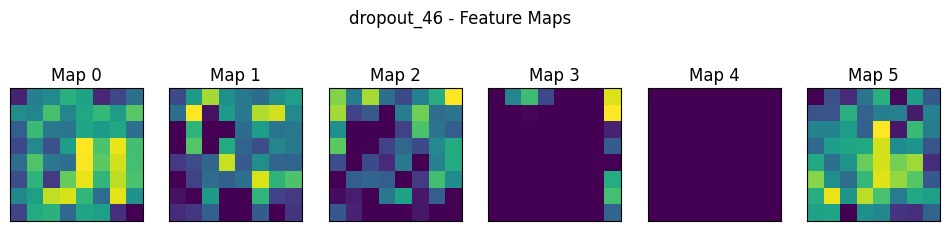



Visualizing Layer 16: batch_normalization_59




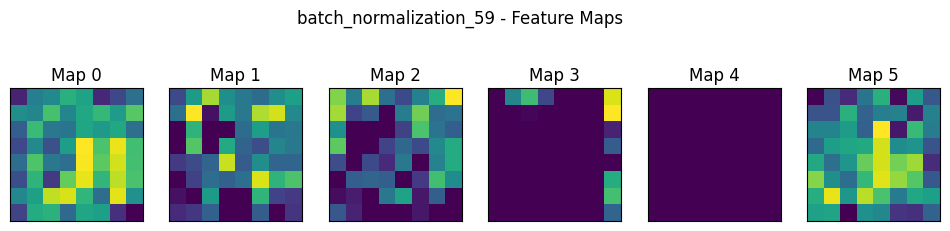



Visualizing Layer 17: max_pooling2d_59




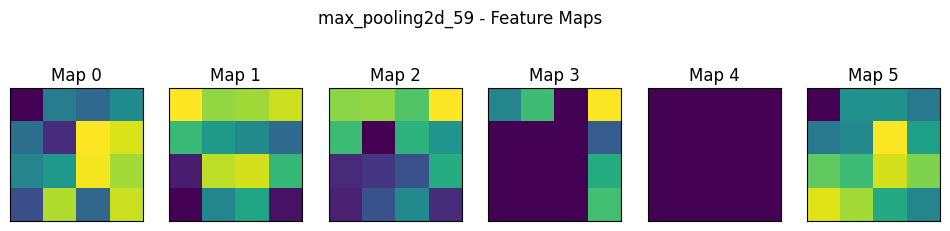



Visualizing Layer 18: flatten_11




<Figure size 1200x200 with 0 Axes>

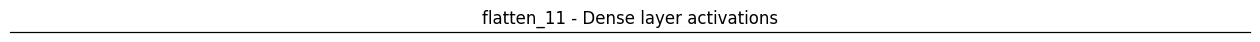



Visualizing Layer 19: dense_22




<Figure size 1200x200 with 0 Axes>

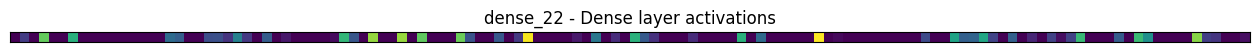



Visualizing Layer 20: dropout_47




<Figure size 1200x200 with 0 Axes>

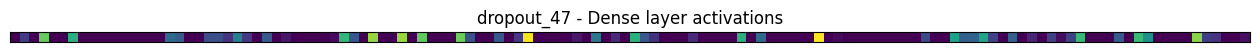



Visualizing Layer 21: dense_23




<Figure size 1200x200 with 0 Axes>

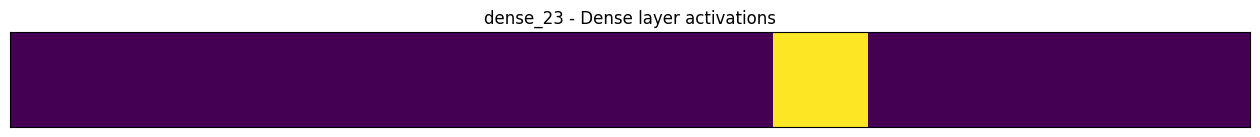

In [277]:
# Set the number of feature maps to display per layer
n_visualizations = 6  # Display up to 6 feature maps per layer

# Iterate over the activations of all layers and display a few feature maps for each layer
for i, layer_activation in enumerate(activations):
    # Extract the name of the layer
    layer_name = model.layers[i].name
    print(f"\n\nVisualizing Layer {i}: {layer_name}\n\n")
    
    # Get the number of dimensions in the activation
    activation_shape = layer_activation.shape

    # Check if the layer activation is 4D (for convolutional layers)
    if len(activation_shape) == 4:  
        n_features = layer_activation.shape[-1]  # Number of filters
        size = layer_activation.shape[1]  # Size of the feature map (height/width, assuming square)

        # Visualize the first few feature maps (let's say 6 feature maps for each layer)
        n_visualizations = min(n_features, 6)  # Show up to 6 feature maps
        
        # Set up the plot grid
        cols = 6  # Display 3 images per row
        rows = math.ceil(n_visualizations / cols)  # Calculate how many rows needed
        
        plt.figure(figsize=(12, 3))  # Adjust figure size for compact visualization
        for feature_map_idx in range(n_visualizations):
            ax = plt.subplot(rows, cols, feature_map_idx + 1)
            plt.matshow(layer_activation[0, :, :, feature_map_idx], cmap='viridis', fignum=False)
            plt.xticks([])
            plt.yticks([])
            plt.title(f"Map {feature_map_idx}")
        
        plt.suptitle(f"{layer_name} - Feature Maps")
        plt.show()

    # Check if the layer activation is 2D (for fully connected layers like Dense)
    elif len(activation_shape) == 2:  
        plt.figure(figsize=(12, 2))  # Adjust figure size for dense layer activations
        plt.matshow(layer_activation[0, :].reshape(1, -1), cmap='viridis')  # Visualize as a row of values
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{layer_name} - Dense layer activations")
        plt.show()

    else:
        print(f"Skipping visualization for layer {layer_name} with shape {activation_shape}")
